# 7.1. From Fully Connected Layers to Convolutions

Summary and Discussion

In this section we derived the structure of convolutional neural networks from first principles. While it is unclear whether this was the route taken to the invention of CNNs, it is satisfying to know that they are the right choice when applying reasonable principles to how image processing and computer vision algorithms should operate, at least at lower levels. In particular, translation invariance in images implies that all patches of an image will be treated in the same manner. Locality means that only a small neighborhood of pixels will be used to compute the corresponding hidden representations. Some of the earliest references to CNNs are in the form of the Neocognitron (Fukushima, 1982).

A second principle that we encountered in our reasoning is how to reduce the number of parameters in a function class without limiting its expressive power, at least, whenever certain assumptions on the model hold. We saw a dramatic reduction of complexity as a result of this restriction, turning computationally and statistically infeasible problems into tractable models.

Adding channels allowed us to bring back some of the complexity that was lost due to the restrictions imposed on the convolutional kernel by locality and translation invariance. Note that it is quite natural to add channels other than just red, green, and blue. Many satellite images, in particular for agriculture and meteorology, have tens to hundreds of channels, generating hyperspectral images instead. They report data on many different wavelengths. In the following we will see how to use convolutions effectively to manipulate the dimensionality of the images they operate on, how to move from location-based to channel-based representations, and how to deal with large numbers of categories efficiently.

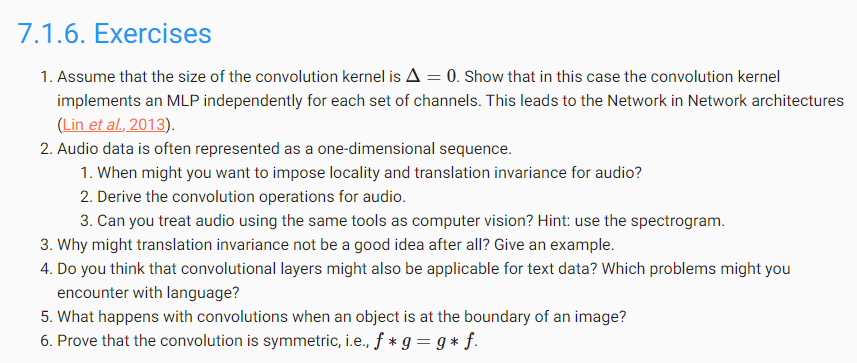

1.



 합성곱의 핵심은 입력의 특정 부분(패치)에 필터를 적용하는 것이다. 커널의 크기가 Δ = 0이라는 것은, 커널이 단일 픽셀에만 적용된다는 의미이다. 즉, 각 입력 위치에서 다중 뉴런(채널별로 다르게)을 적용해 출력을 계산하는데, 이 과정이 MLP의 원리와 동일하다. 이를 수식으로 설명하면: 𝑦 𝑖 = 𝑊 𝑖 𝑥 𝑖 + 𝑏 𝑖



 각 𝑖 에 대해 독립적으로 연산이 이루어지므로, 이것은 MLP가 각각의 입력 채널에 대해 독립적으로 적용되는 경우와 같다.

이 방식은 Network in Network (NiN) 구조와 연결된다. NiN은 1x1 합성곱을 통해 각 위치에 대해 독립적으로 MLP를 적용하여 채널별로 정보를 학습한다.



2.


1) Audio 에서 Locality를 적용하는 이유는 짧은 시간 동안의 패텅을 포착하기 위해서이다. Translation invariance 는 음성의 위치가 바뀌어도 같은 패턴을 인식할 수 있게 한다. 예를 들어, 동일한 음이 오디오 시퀀스의 어느 위치에 있든 감지할 수 있도록 한다.

2) Audio data는 시간에 따른 진폭 또는 주파수 변화를 기록한 1차원 시퀀스이다. 따라서 1D 합성곱을 사용하여 패턴을 학습할 수 있다.



3) Spectrogram은 Audio 신호의 시간-주파수 표현으로, 시각적으로 분석할 수 있는 2차원 이미지와 같다. CNN을 사용하여 이 2D 데이터를 분석하는 방식으로 오디오 패턴을 감지할 수 있다.



3.


Translation invariance는 패턴의 위치와 관계없이 동일한 패턴으로 인식한다는 것을 의미한다. 하지만 어떤 경우에는 패턴의 위치가 중요할 수 있다. 예를 들어 이미지에서 객체가 특정 위치에 있어야만 유효한 경우나 자연어 처리에서 단어 순서가 중요한 경우에는 이동 불변성이 적합하지 않다. 또한 얼굴인식에서도 눈, 코, 입의 상대적인 위치가 중요하다. 위치 정보가 손실되면 잘못된 인식이 발생할 수 있다.



4.


텍스트데이터에서 CNN을 사용하는 것은 가능하다. 특히 단어의 지역적인 관계를 포착하는 데 유리하다. CNN은 1D 합성곱을 통해 텍스트 내에서 특정 패턴을 학습할 수 있다. 하지만 텍스트는 순차적인 특성이 강하기 때문에 문맥을 포착하는 데 어려움이 있을 수 있다. 이 문제를 해결하기 위해서는 RNN이나 Transformer 같은 모델이 더 적합할 수 있다.



5.


이미지의 경계에 객체가 있을 때, 필터의 일부는 이미지 외부를 참조하려 할 수 있다. 이 문제를 해결하기 위해 Padding 이 사용된다. 패딩이 없을 경우, 경계에 있는 정보는 손실되거나 부분적인 정보만 필터에 의해 학습될 수 있다



6.


합성곱의 대칭성. 합성곱의 정의에 따라 변수를 바꾸면 두 식이 동일하므로 합성곱은 대칭적이다.

# 7.2. Convolutions for Images

In [1]:
# !pip install d2l

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
def corr2d(X, K):
  """Compute 2D cross-correLation."""
  h, w = K.shape
  Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (X[i:i + h, j:j + w]*K).sum()
  return Y

In [4]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [5]:
class Conv2D(nn.Module):
  def __init__(self, kernel_size):
    super().__init__()
    self.weight = nn.Parameter(torch.rand(kernel_size))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self, x):
    return corr2d(x, self.weight) + self.bias


In [6]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0, -1.0]])

In [8]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [10]:
conv2d = nn.LazyConv2d(1, kernel_size=(1, 2), bias=False)

X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # Learning rate

for i in range(10):
  Y_hat = conv2d(X)
  l = (Y_hat - Y) ** 2
  conv2d.zero_grad()
  l.sum().backward()
  # Update the kernel
  conv2d.weight.data[:] -= lr * conv2d.weight.grad
  if (i+1) % 2 ==0:
    print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 7.898
epoch 4, loss 2.022
epoch 6, loss 0.625
epoch 8, loss 0.222
epoch 10, loss 0.085


In [11]:
conv2d.weight.data.reshape((1, 2))

tensor([[ 1.0178, -0.9589]])

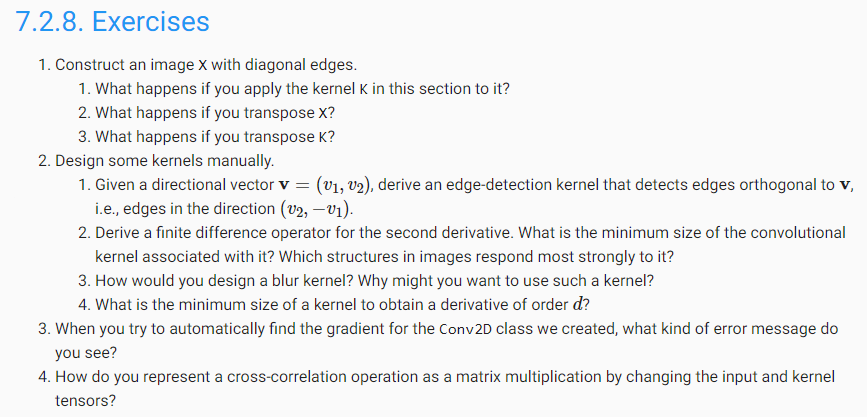

1.


Diagonal edges를 가진 이미지 X

1) K=[1.0,−1.0] 적용 => 각 인접한 두 픽셀 간의 차이


대각선 방향의 엣지를 감지할 것이고, 각 행의 인접한 픽셀들 간의 차이를 계산하여 엣지의 위치를 탐지할 것이다.

2) X를 전치했을 때도 X와 같은 모습일 것이기 때문에 동일한 결과를 얻을 수 있다.

3) K는 1차원 이므로 전치가 적용되지 않는다.


2.


1) 엣지 검출 커널. V = (v1, v2)와 직교하는 방향으로 엣지를 검출하기 위한 커널은

K = [[v1, v2], [-v1, -v2]] 이다


2) Second derivative을 위한 finite difference operator 유도. Finite difference operator는 이미지에서 곡률을 감지한다. 라플라시안(Laplacian) 필터는 2차 미준 연산자를 구현한 커널로, 가장 많이 사용되는 예시이다.

라플라시안 커널의 예시: K = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]

이 커널은 이미지의 곡선이나 모서리 구조에서 가장 강하게 반응하며, 특히 곡률이 높은 영역에서 값이 크게 변한다. 최소 크기는 3*3으로 설정할 수 있다.

3) Blur Kernel 은 이미지의 세부 정보를 제거하거나 부드럽게 만들기 위해 사용된다. Gaussian Blur Kernel 이 가장 널리 사용되는 예이다. 가우시안 커널은 픽셀 값들이 주변 값들로 평균화되는 방식으로 이미지를 부드럽게 만든다.

예시: K = [[1, 2, 1], [2, 4, 2], [1, 2, 1]]

이 커널을 사용하면 픽셀 값들이 주변 값들과 혼합되어 이미지의 노이즈를 줄일 수 있다. 블러 커널은 이미지를 부드럽게 만들어 중요한 정보가 더 잘 보이도록 하거나, 이미지 전처리 과정에서 사용된다.


4) 도함수의 차수 d에 따라 필요한 커널의 크기가 결정된다. 일반적으로 d차 도함수를 계산하기 위해서는 최소 (d+1)^2 크기의 커널이 필요하다.

3.

그래디언트를 계산할 때 발생하는 문제는 역전파 중 입력 크기 불일치, Conv2D 클래스 내에서 파라미터에 대한 잘못된 정의로 인해 발생할 수 있다.

Dimension mismatch error: 입력 데이터의 차원과 커널의 차원이 맞지 않으면 그래디언트를 계산할 수 없다.

Non-differentiable operation: 특정 연산이 미분 불가능한 경우, 그라디언트를 계산할 수 없다는 메세지가 출력될 수 있다.

4.

Cross-Correlation 연산은 Convolution 과 매우 유사하지만, 커널을 뒤집지 않는다는 점에서 차이가 있다. Cross-correlation을 행렬 곱셈으로 변환하려면, 입력 이미지를 행렬로 patch하고, 커널도 행렬로 변환한 후 두 행렬을 곱하는 방식으로 계산할 수 있다.



# 7.3. Padding and Stride


In [12]:
import torch
from torch import nn

In [13]:
def comp_conv2d(conv2d, X):
  X = X.reshape((1, 1) + X.shape)
  Y = conv2d(X)
  return Y.reshape(Y.shape[2:])

conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [14]:
conv2d = nn.LazyConv2d(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [15]:
conv2d = nn.LazyConv2d(1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [16]:
conv2d = nn.LazyConv2d(1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

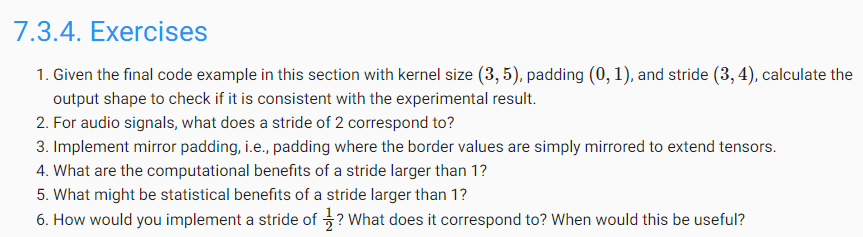

1. 커널 크기 (3, 5), 패딩 (0, 1), 스트라이드 (3, 4)에서 출력 크기 계산

출력 높이 = (입력 높이 - 커널 높이 + 2*패딩 높이)/(스트라이드 높이) + 1 = 3.67

출력 너비 = (입력 너비 - 커널 너비 + 2*패딩 너비)/(스트라이드 너비) + 1 = 2



출력 크기는 (3, 2)



2. Audio signal에서 stride=2는 샘플 간격을 2배로 늘려 두 샘플 중 하나만 사용해 데이터를 처리하는 것을 의미. 이는 입력 신호의 길이를 절반으로 줄여 데이터를 더 적게 사용하므로 연산량이 줄고, 처리 속도는 빨라지지만 세부 정보가 덜 반영될 수 있다.



3. Mirror padding은 경계의 값을 반사하는 방식으로 패딩을 추가하는 것.

```
import torch.nn.functional as F

X = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
X_padded = F.pad(X, (1, 1, 1, 1), mode='reflect')
print(X_padded)
```




4. stride가 1보다 큰 경우의 계산적 이점: 데이터의 중복된 계산을 피할 수 있어 연산 효율이 좋아진다. 모델을 더 빠르게 학습시키고, 메모리 사용량을 줄이는 데 효과적이다.



5. stride 가 1보다 큰 경우의 통계적 이점: 입력 데이터의 특정 구역에서 더 전역적인 특징을 추출할 수 있다. 특히 연속성이 강한 데이터에서는 더 큰 간격의 정보를 얻어 과적합을 방지할 수 있으며, 데이터를 압축하면서 중요한 특징만을 뽑아내는 효과가 있다.



6. stride=1/2 를 구현하는 방법: 합성곱 연산에서 바로 구현할 수는 없지만, upsampling 기법을 사용하여 비슷한 효과를 낼 수 있다. 예를 들어 입력 데이터 사이사이에 0을 채워넣는 방식으로 크기를 두 배로 늘린 다음, 일반적인 합성곱 연산을 수행하면 된다. 이는 Transposed convolution, Fractional stride 라고 부르기도 한다. 이 방식은 주로 이미지를 고해상도로 복원하거나 더 세밀한 정보를 필요로 하는 경우에 유용하다.



+++ 개념 정리



1. LazyConv2d: Pytorch 에서 제공하는 합성곱 계층의 변형으로, 초기화 시 입력 채널 수를 명시적으로 지정하지 않고 나중에 데이터가 실제로 입력될 때 자동으로 입력 채널 수를 설정하는 계층. 주로 네트워크으 ㅣ입력 형태를 미리 알기 어려운 경우에 유용하게 사용된다.

# 7.4. Multiple Input and Multiple Output Channels


In [17]:
import torch
from d2l import torch as d2l

In [18]:
def corr2d_multi_in(X, K):
  return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

In [19]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

In [20]:
def corr2d_multi_in_out(X, K):
  return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [21]:
K = torch.stack((K, K+1, K+2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [22]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [23]:
def corr2d_multi_in_out_1x1(X, K):
  c_i, h, w = X.shape
  c_o = K.shape[0]
  X = X.reshape((c_i, h * w))
  K = K.reshape((c_o, c_i))
  Y = torch.matmul(K, X)
  return Y.reshape((c_o, h, w))

In [24]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

# 7.5. Pooling


In [25]:
import torch
from torch import nn
from d2l import torch as d2l

In [26]:
def pool2d(X, pool_size, mode='max'):
  p_h, p_w = pool_size
  Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      if mode == 'max':
        Y[i, j] = X[i: i + p_h, j:j+p_w].max()
      elif mode == 'avg':
        Y[i, j] = X[i:i + p_h, j:j + p_w].mean()
  return Y

In [27]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [28]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

In [29]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [30]:
pool2d = nn.MaxPool2d(3)
# Pooling has no model parameters, hence it needs no initialization
pool2d(X)

tensor([[[[10.]]]])

In [31]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [32]:
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [33]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [34]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

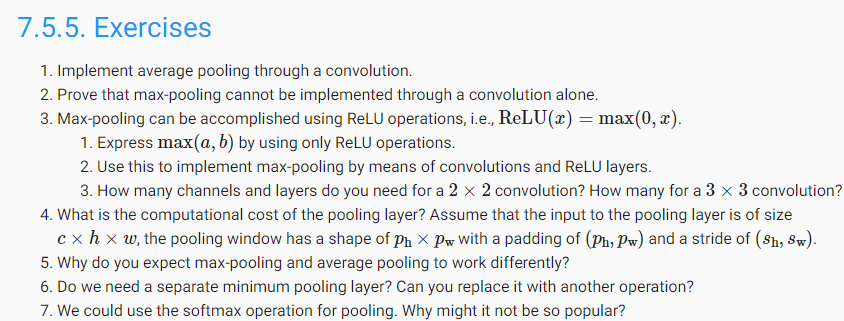

1.

Average pooling은 필터 크기를 지정하고 각 필터 영역에서 평균을 구하여 수행할 수 있다.



2.

Max pooling은 각 필터 영역에서 가장 큰 값을 선택하는 비선형 연산이다. 반면 Convolution은 입력 값들의 선형 결합을 수행하므로, Convolution 만으로는 max pooling과 같은 비선형 기능을 구현할 수 없다.



3.

1) max(a, b) = ReLU(a-b) + b

2) Convolution 과 ReLU 계층을 통해 max-pooling을 구현할 수 있다. 각 필터가 특정 위치에서 값을 비교한 후 ReLU로 큰 값을 선택하게 하면 max-pooling과 동일한 결과를 얻을 수 있다.



4.

(전체 풀링 연산의 총 계산량) = (채널 수 c) * (출력 높이 h) * (출력 너비 w) * (ph*pw)



5.

Max-pooling: 주로 중요한 특징을 남기기 때문에 더 선명한 특징 추출 가능. 정보의 압축을 중시

Average pooling: 전체적인 값을 고르게 반영하여 노이즈가 적은 결과. 전반적인 특성 유지가 중요한 경우 사용



6.

Min pooling은 각 창 영역 내에서 가장 작은 값을 선택하는 방식.

최대값이나 평균 값이 더욱 중요한 경우가 많기 때문에 잘 사용하지 않음. 이상치 탐지나 노이즈 제거 등 특수한 목적이 있는 상황에서 사용



7.

Softmax는 각 값의 상대적인 크기를 확률로 변환해주지만, 풀링의 목적은 특정 값들을 추출하거나 압축하는 데 있다. Softmax는 복잡한 계산을 요구하며, 풀링처럼 간단하고 빠른 특징 추출과는 목적이 다르므로 사용되지 않는다.

# 7.6. Convolutional Neural Networks (LeNet)


In [35]:
import torch
from torch import nn
from d2l import torch as d2l

In [36]:
def init_cnn(module):
  if type(module) == nn.Linear or type(module) == nn.Conv2d:
    nn.init.xavier_uniform_(module.weight)

class LeNet(d2l.Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.LazyConv2d(16, kernel_size=5),
        nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.LazyLinear(120),
        nn.Sigmoid(),
        nn.LazyLinear(83),
        nn.Sigmoid(),
        nn.LazyLinear(num_classes)

    )

In [37]:
@d2l.add_to_class(d2l.Classifier)
def layer_summary(self, X_shape):
  X = torch.randn(*X_shape)
  for layer in self.net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = LeNet()
model.layer_summary((1, 1, 28, 28))

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 83])
Sigmoid output shape:	 torch.Size([1, 83])
Linear output shape:	 torch.Size([1, 10])


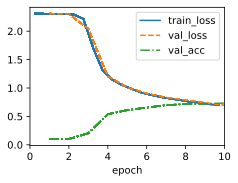

In [38]:
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128)
model = LeNet(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model, data)

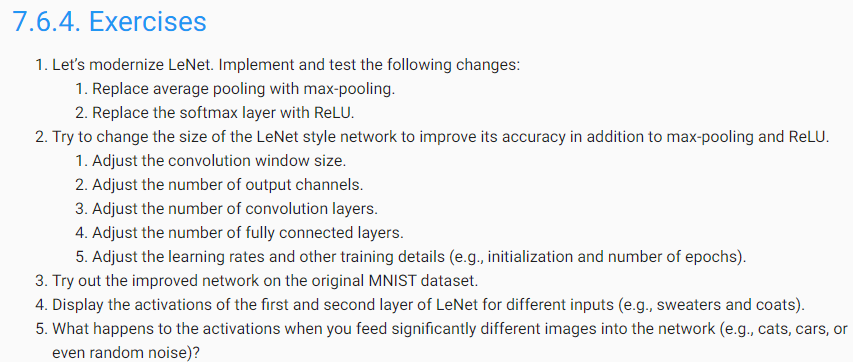

1. average pooling 대신 max pooling을, softmax 대신 ReLU 적용
```
class LeNet(d2l.Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
        nn.LazyConv2d(6, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling으로 변경
        nn.LazyConv2d(16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),  # Max Pooling으로 변경
        nn.Flatten(),
        nn.LazyLinear(120),
        nn.ReLU(),  # Softmax 대신 ReLU 사용
        nn.LazyLinear(83),
        nn.ReLU(),  # Softmax 대신 ReLU 사용
        nn.LazyLinear(num_classes)
    )
```

2.

1) Convolution window size 변경

kernel_size



2) the number of output channel 변경

Convolution 레이어의 out_channels 파라미터를 통해 변경




3) the number of convolution layers 변경

모델 정의 부분에서 합성곱 레이어를 수정하여 변경



4) the number of fully connected layers

``` nn.LazyLinear(),  ```
레이어를 추가하거나 제거하여 변경



5) learning rate 등 training detail 변경

ex: trainer = d2l.Trainer(lr=0.01, max_epochs=20, num_gpus=1)

파라미터를 통해 변경



3.

MNIST 데이터셋: 손글씨 숫자 (0~9) 데이터셋으로, 28x28 크기의 흑백 이미지로 구성되어 있음. 딥러닝 모델을 테스트하고 학습하는 데 자주 사용되는 기본적인 이미지 데이터셋

```
# MNIST 데이터셋 로드
data = d2l.MNIST(batch_size=128)

# 모델 정의 및 초기화
model = LeNet(lr=0.1)  # 개선된 LeNet 모델
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)

# Trainer 설정 및 훈련 시작
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
trainer.fit(model, data)  # 훈련 실행
```

4. Displaying activations of the first and second layer

첫번째 두번째 활성화 값을 시각화하는 방법
```
# 입력 데이터를 LeNet 모델에 통과시키고 각 레이어의 활성화 값 추출
def get_activations(model, layer_num, input_tensor):
    layers = list(model.net.children())  # Sequential 네트워크의 각 레이어 가져오기
    activation = input_tensor
    for i in range(layer_num + 1):  # 지정된 레이어까지 통과
        activation = layers[i](activation)
    return activation

# 가상의 스웨터와 코트 이미지 예시
sweater_image = torch.randn(1, 1, 28, 28)  # 가상 스웨터 이미지
coat_image = torch.randn(1, 1, 28, 28)     # 가상 코트 이미지

# 첫 번째 레이어 활성화
activation_layer1_sweater = get_activations(model, 0, sweater_image)
activation_layer1_coat = get_activations(model, 0, coat_image)

# 두 번째 레이어 활성화
activation_layer2_sweater = get_activations(model, 2, sweater_image)
activation_layer2_coat = get_activations(model, 2, coat_image)

# 활성화 결과 출력
print("첫 번째 레이어 스웨터 이미지 활성화:", activation_layer1_sweater)
print("첫 번째 레이어 코트 이미지 활성화:", activation_layer1_coat)
print("두 번째 레이어 스웨터 이미지 활성화:", activation_layer2_sweater)
print("두 번째 레이어 코트 이미지 활성화:", activation_layer2_coat)
```

5. 확실하게 다른 이미지를 모델에 입력했을 때 활성화 변화

다른 데이터를 입력하면 모델이 예상치 못한 특징을 추출하거나 활성화 값이 달라질 수 있음

```
# 가상의 고양이, 자동차, 잡음 이미지 생성
cat_image = torch.randn(1, 1, 28, 28)   # 고양이 이미지
car_image = torch.randn(1, 1, 28, 28)   # 자동차 이미지
noise_image = torch.randn(1, 1, 28, 28) # 무작위 잡음 이미지

# 첫 번째 레이어에 대한 활성화 값
activation_cat = get_activations(model, 0, cat_image)
activation_car = get_activations(model, 0, car_image)
activation_noise = get_activations(model, 0, noise_image)

# 활성화 결과 출력
print("고양이 이미지 첫 번째 레이어 활성화:", activation_cat)
print("자동차 이미지 첫 번째 레이어 활성화:", activation_car)
print("잡음 이미지 첫 번째 레이어 활성화:", activation_noise)
```

# 8.2. Networks Using Blocks (VGG)


In [39]:
import torch
from torch import nn
from d2l import torch as d2l

In [40]:
def vgg_block(num_convs, out_channels):
  layers = []
  for i in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [41]:
class VGG(d2l.Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    for (num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes)
    )
    self. net.apply(d2l.init_cnn)

In [42]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224)
)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


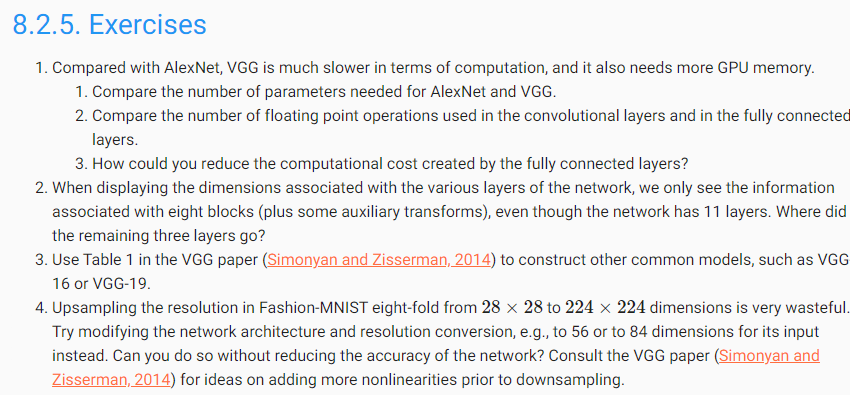

1. VGG와 AlexNet의 계산 성능 비교

1) 파라미터 수 비교

AlexNet: 약 6천만 개 (얕은 신경망 구조)

VGG-16: 약 1억 3천 8백만 개 (깊은 신경망 구조)



2) 합성곱 계층과 완전 연결 계층에서 연산량 비교

AlexNet: 상대적으로 큰 필터를 사용. 계층의 수가 적음. 연산량 적음

VGG: 많은 합성곱 계층. 필터 크기가 작지만 깊이가 깊어 연산량 증가



3) 완전 연결 계층에서 계산비용 줄이기

VGG는 완전 연결 계층에서 드롭아웃을 사용하여 계산량을 줄이고, 과적합을 방지



2.

VGG 네트워크에서 8개의 블록만 나타나지만 실제로는 총 11개의 레이어가 존재. 남은 3개의 레이어는 보조적인 역할을 하는 완전 연결 계층과 드롭아웃 계층. 이는 네트워크의 마지막 부분에서 주로 사용되며, 분류 작업을 위한 최종 레이어로 작동



3.

블록당 합성곱 계층 수를 조절하여 모델 구성 가능



4. Fashion-MNIST 데이터셋의 해상도를 8배로 업샘플링

Fashion-MNIST 데이터셋의 이미지는 28*28 크기인데, 이를 224*224로 업샘플링 하는 것은 많은 계산 비용이 필요. 이를 해결하기 위해서는 입력 해상도를 56*56 또는 84*84 같은 중간 크기로 변환. 이를 통해 계산 효율성을 유지하며 성능 저하를 방지.




# 8.6. Residual Networks (ResNet) and ResNeXt

In [44]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [45]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [46]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

In [47]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [48]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [49]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [50]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [51]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


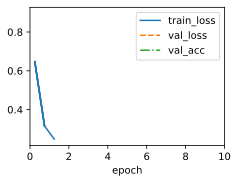

In [ ]:
model = ResNet18(lr=0.1)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

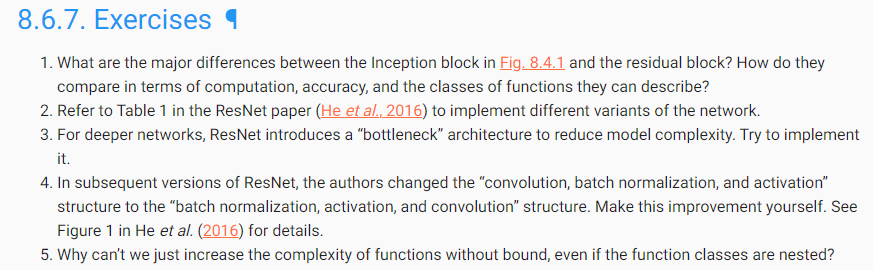

1.

Inception Block: 여러 크기의 필터를 병렬로 사용하는 방식. 모델이 여러 수준의 특징을 동시에 학습. 병렬로 다양한 필터를 사용하기 때문에 계산량이 비교적 많아짐

계산량 많음

복잡한 특징 추출에 유리

넓은 범위의 함수 클래스에서 학습 가능



Residual Block: 입력을 그대로 출력에 전달하는 skip connection을 추가하여 기울기 소실 문제를 해결. 이 구조는 매우 깊은 네트워크에서도 성능 저하 없이 학습 가능.

계산비용이 상대적으로 적음

깊은 네트워크에서 성능 유지에 유리

복잡한 함수 설명에 용이하지만 필터 스케일이 고정적



2.

Layer 수를 조절하여 다양한 변형 네트워크 구현 가능



3.

Bottleneck 구조는 깊은 네트워크에서 사용됨. 이 구조는 1x1 합성곱을 사용하여 채널 수를 줄인 후, 3x3 합성곱을 적용하고, 다시 1x1 합성곱을 통해 원래 채널 수로 복원하는 방식. 이를 통해 계산 비용을 줄이면서 깊은 네트워크 구현 가능



4.

ResNet 논문의 최신 버전에서는 블록 내 연산 순서를

Convolution > Batch > Normalization > Activation 에서

Batch Normalization > Activation > Convolution 으로 변경

```
class NewResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(NewResidualBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        out = F.relu(self.bn1(x))
        out = self.conv1(out)
        out = F.relu(self.bn2(out))
        out = self.conv2(out)
        out += self.shortcut(x)
        return F.relu(out)
 ```

5.

함수의 클래스가 중첩된 경우, 이론적으로 더 큰 함수 클래스는 더 작은 클래스의 함수를 포함해야함. 하지만 함수의 복잡도를 계속해서 증가시키는 것이 항상 더 나은 결과를 보장하는 것은 아님



과적합, 최적화의 어려움, 계산 비용 과다 등의 이유로 무조건 복잡성을 늘리기보다는 적절한 복잡도를 유지하는 것이 중요